In [ ]:
!pip install rdkit-pypi
!pip install pandas
!pip install Pillow
!pip install matplotlib
!pip install pydot
!sudo apt-get -qq install graphviz

In [ ]:
# Gerekli kütüphanelerin içe aktarılması
import os

# TensorFlow ve Keras modülleri
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Veri işleme ve görselleştirme için numpy, pandas ve matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Uyarı mesajlarını geçici olarak kapatmak için
import warnings

# RDKit'in içe aktarılması
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# TensorFlow ve RDKit loglarını geçici olarak kapatma
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

# Rastgele tohumları ayarlama
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
csv_path = "/content/drive/MyDrive/DrugDrugInteraction/HIV.csv"

df = pd.read_csv(csv_path, usecols=[1,2,3])
df.iloc[100:107]

,smiles,activity,HIV_active
100,O=C(CCc1ccc(O)cc1)NCCc1ccc(O)cc1,CM,1
101,Cc1cn(C2CC(N=[N+]=[N-])C(COC(=O)CCCCCCCCCc3ccc...,CA,1
102,O=S(=O)(Cc1ccccc1)SCc1ccccc1,CI,0
103,CCOC(=O)NC(=N)SCc1ccccc1.Cl,CI,0
104,O=C(O)C1CSC2c3ccccc3C(=O)N12,CI,0
105,Cc1cn(C2CC(N=[N+]=[N-])C(COC(=O)CCCCCCCCCCBr)O...,CA,1
106,CCCSc1nn2cc(NC(=O)OC)nc2s1,CI,0


In [ ]:
class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0  # Özellik boyutu
        self.features_mapping = {}  # Özellik eşlemesi sözlüğü
        # Her bir özellik kümesi için döngü
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            # Özellik eşlemesi sözlüğü oluşturma
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)  # Özellik boyutunu güncelleme

    def encode(self, inputs):
        output = np.zeros((self.dim,))  # Çıktıyı sıfırlar dizisi olarak başlatma
        # Her bir özellik kümesi için döngü
        for name_feature, feature_mapping in self.features_mapping.items():
            # Girişteki özelliği al
            feature = getattr(self, name_feature)(inputs)
            # Eğer özellik eşlemesi sözlüğünde yoksa, bir sonraki özelliğe geç
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0  # Özelliği kodlama
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    # Atom özelliklerini kodlayan metotlar
    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1  # Bağ boyutunu bir artırma

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0  # Bağ yoksa, son indeksi 1.0 olarak ayarlama
            return output
        output = super().encode(bond)  # Bağ özelliklerini kodlama
        return output

    # Bağ özelliklerini kodlayan metotlar
    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


# Atom featurizer örneği
atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

# Bağ featurizer örneği
bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


In [ ]:
# Fonksiyon, verilen bir SMILES dizgisinden bir kimyasal molekül oluşturur.
# Bu molekül, sanitize işlemi gerçekleştirilerek oluşturulur.
# Sanitize işlemi başarısız olursa, hatayı yakalar ve bu adımdan geçmeden tekrar dener.
# Son olarak, stereo kimyasal bilgileri atanır.
def molecule_from_smiles(smiles):
    # SMILES dizgisinden molekül oluştur
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # Sanitize işlemi başarısız olursa, hatayı yakala ve hatayı içermeyen bir şekilde tekrar dene
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    # Stereo kimyasal bilgileri ata
    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule

# Molekülden bir graf oluşturur.
def graph_from_molecule(molecule):
    # Atom ve bağ özelliklerini depolamak için boş listeler oluştur
    atom_features = []
    bond_features = []
    pair_indices = []

    # Moleküldeki her atom için dön
    for atom in molecule.GetAtoms():
        # Atom özelliklerini kodla ve listeye ekle
        atom_features.append(atom_featurizer.encode(atom))

        # Kendi kendine döngüler ekleyin (self-loops)
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        # Atomun komşuları üzerinde döngü yapın
        for neighbor in atom.GetNeighbors():
            # Atomlar arasındaki bağı al
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            # Atom çifti indekslerini ve bağ özelliklerini listeye ekle
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    # Atom özellikleri, bağ özellikleri ve çift indekslerini numpy dizilerine dönüştür
    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)

# SMILES dizgilerinden oluşan bir listeyi alır ve her bir SMILES dizgisi için bir graf listesi döndürür.
def graphs_from_smiles(smiles_list):
    # Graf özelliklerini depolamak için boş listeler oluştur
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    # Her bir SMILES dizgisi için döngü yap
    for smiles in smiles_list:
        # SMILES dizgisinden molekül oluştur
        molecule = molecule_from_smiles(smiles)
        # Molekülü graf olarak kodla
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        # Graf özelliklerini ilgili listelere ekle
        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # tf.data.Dataset için ragged tensors haline getirilmiş listeleri döndür
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )

# Veri setini karıştırır ve train, valid ve test setleri oluşturur.
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: Verilerin %80'i
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].HIV_active

# Valid set: Verilerin %19'u
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.90)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].HIV_active

# Test set: Verilerin %1'i
test_index = permuted_indices[int(df.shape[0] * 0.90) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].HIV_active


SMILES:	O=C(CCc1ccc(O)cc1)NCCc1ccc(O)cc1
BBBP:	1
Molecule:


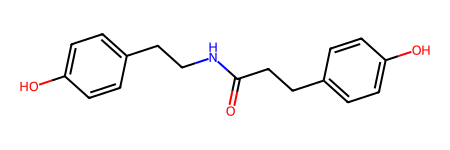

In [ ]:
print(f"SMILES:\t{df.smiles[100]}\nBBBP:\t{df.HIV_active[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [ ]:
df.iloc[train_index].smiles
x_train

(<tf.RaggedTensor [[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
    0.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0,
    0.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    1.0],
   [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0,
    0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    1.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
    0.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,
    0.0],
   [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0

In [ ]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)

Graph (including self-loops):
	atom features	 (21, 29)
	bond features	 (65, 7)
	pair indices	 (65, 2)


In [ ]:
def prepare_batch(x_batch, y_batch):
    """Bir (alt)graf grubunu tek bir global (bağlantısız) grafa birleştirir.
    """

    atom_features, bond_features, pair_indices = x_batch

    # Her bir graf (molekül) için atom ve bağ sayısını alın
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # (Alt)grafları daha sonra modele toplamak için kullanılacak bölmeli indeksleri (molecule_indicator) alın
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # (Alt)grafları birleştirerek global (bağlantısız) bir graf oluşturun. 'pair_indices' üzerine 'increment'
    # eklemek (ve yığın tensörlerini birleştirmek) global grafi gerçekleştirir
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    """Tensorflow veri seti oluşturucu.

    X: Giriş verisi
    y: Çıkış verisi
    batch_size: Toplu iş boyutu
    shuffle: Veri setini karıştırma durumu

    """
    # Tensorflow veri setini oluştur
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    # Veri setini toplu iş boyutuna böl ve hazır hale getir
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


In [ ]:
class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        # Giriş şeklinden atom ve bağ boyutlarını alın
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        # Ağırlıkları tanımlayın
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Bağ özelliklerine lineer dönüşüm uygulayın
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Daha sonra komşuluk biriktirmek için yeniden şekillendirin
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Komşu atom özelliklerini alın
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Komşuluk biriktirme işlemi
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        # Atom boyutunu alın
        self.atom_dim = input_shape[0][-1]
        # EdgeNetwork katmanını tanımlayın
        self.message_step = EdgeNetwork()
        # Yenileme adımı için GRU hücresini tanımlayın
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Eğer istenen birim sayısı atom boyutunu aşıyorsa atom özelliklerini doldurun.
        # Alternatif olarak, burada bir yoğun katman kullanılabilir.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Mesaj iletiminin birkaç adımını gerçekleştirin
        for i in range(self.steps):
            # Komşulardan bilgi biriktirin
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # GRU adımı aracılığıyla düğüm durumunu güncelleyin
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


In [ ]:
class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):
        # Girişten atom özelliklerini ve molekül göstergelerini al
        atom_features, molecule_indicator = inputs

        # Alt grafikleri elde et
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Alt grafikleri doldur ve yığ
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Boş alt grafikleri kaldır (genellikle veri kümesindeki son toplu işlem için)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        # PartitionPadding katmanını tanımla
        self.partition_padding = PartitionPadding(batch_size)

        # MultiHeadAttention ve yoğun katmanlar oluştur
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )

        # Normalleme katmanları
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

        # Ortalama havuzlama katmanı
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        # PartitionPadding ile doldurulmuş girişi al
        x = self.partition_padding(inputs)

        # Dolgu maskesi oluştur
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]

        # Dikkat çıktısını al
        attention_output = self.attention(x, x, attention_mask=padding_mask)

        # Projeksiyon katmanları uygula
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))

        # Ortalama havuzlama yap ve çıktıyı döndür
        return self.average_pooling(proj_output)


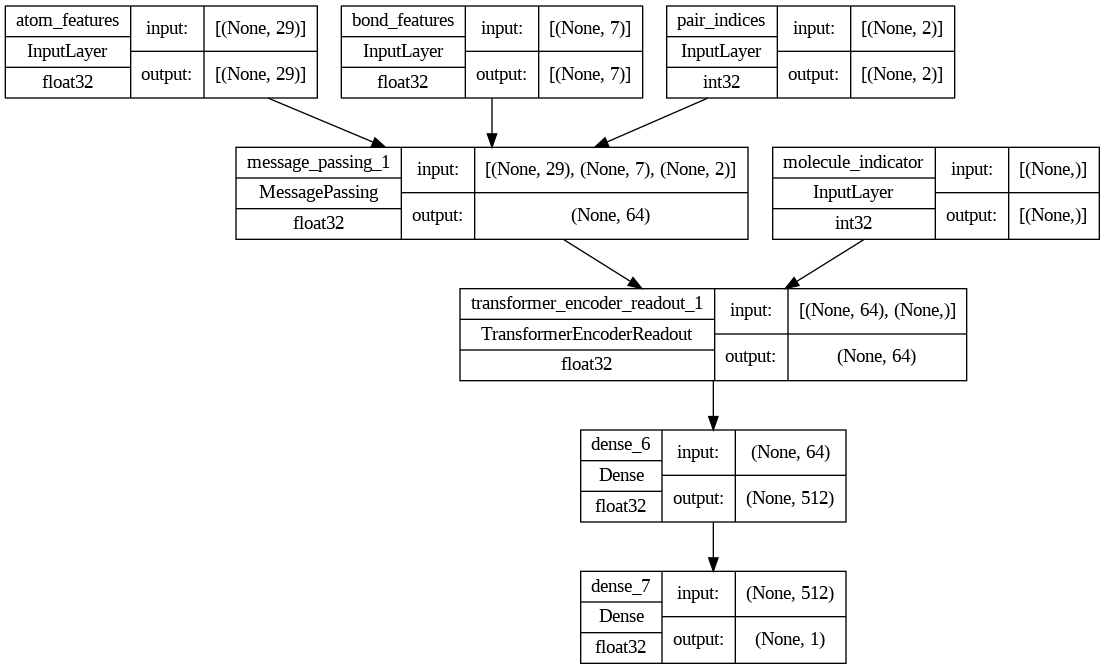

In [ ]:
def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):
    # Giriş katmanları oluştur
    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    # Mesaj iletimi ve dönüşümünü gerçekleştiren katmanları uygula
    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    # Transformer kodlayıcı ve çıkış katmanlarını uygula
    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    # Yoğun katmanlar ekle
    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    # Modeli oluştur
    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


# MPNN modelini oluştur
mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

# Modeli derle
mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

# Modelin yapısını görselleştir
keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)


In [ ]:
train_dataset = MPNNDataset(x_train, y_train)
train_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

Epoch 1/30
73/73 - 48s - loss: 0.4520 - AUC: 0.8240 - val_loss: 0.6141 - val_AUC: 0.8323 - 48s/epoch - 657ms/step
Epoch 2/30
73/73 - 37s - loss: 0.4075 - AUC: 0.8535 - val_loss: 0.6123 - val_AUC: 0.8346 - 37s/epoch - 510ms/step
Epoch 3/30
73/73 - 36s - loss: 0.4007 - AUC: 0.8582 - val_loss: 0.6443 - val_AUC: 0.8372 - 36s/epoch - 492ms/step
Epoch 4/30
73/73 - 37s - loss: 0.4022 - AUC: 0.8583 - val_loss: 0.6660 - val_AUC: 0.8420 - 37s/epoch - 510ms/step
Epoch 5/30
73/73 - 36s - loss: 0.4002 - AUC: 0.8615 - val_loss: 0.7002 - val_AUC: 0.8423 - 36s/epoch - 500ms/step
Epoch 6/30
73/73 - 38s - loss: 0.3950 - AUC: 0.8617 - val_loss: 0.6930 - val_AUC: 0.8443 - 38s/epoch - 516ms/step
Epoch 7/30
73/73 - 33s - loss: 0.3926 - AUC: 0.8639 - val_loss: 0.6770 - val_AUC: 0.8476 - 33s/epoch - 458ms/step
Epoch 8/30
73/73 - 35s - loss: 0.3856 - AUC: 0.8664 - val_loss: 0.6404 - val_AUC: 0.8548 - 35s/epoch - 477ms/step
Epoch 9/30
73/73 - 33s - loss: 0.3876 - AUC: 0.8595 - val_loss: 0.6660 - val_AUC: 0.8500

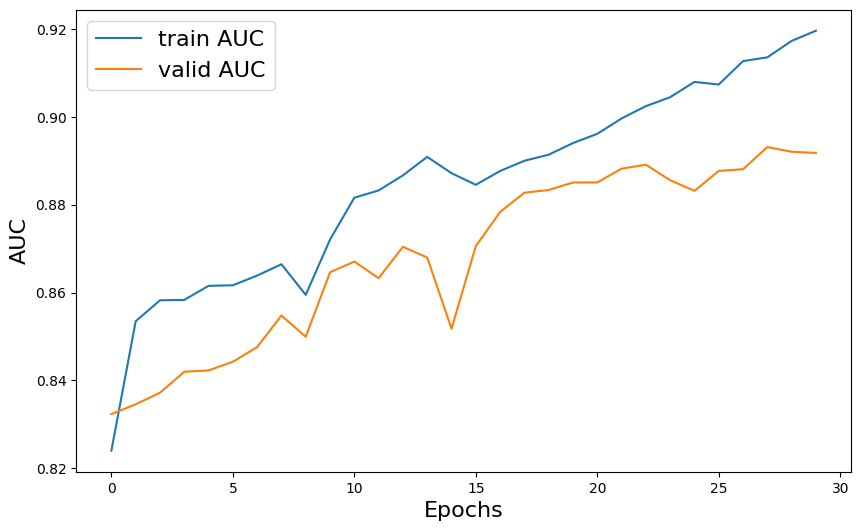

In [ ]:
# Eğitim, doğrulama ve test veri kümelerini oluştur
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

# Modeli eğit
history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=30,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},  # Sınıf ağırlıkları tanımla
)

# Eğitim geçmişini görselleştir
plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")  # Eğitim AUC
plt.plot(history.history["val_AUC"], label="valid AUC")  # Doğrulama AUC
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)


10/10 [==============================] - 3s 192ms/step


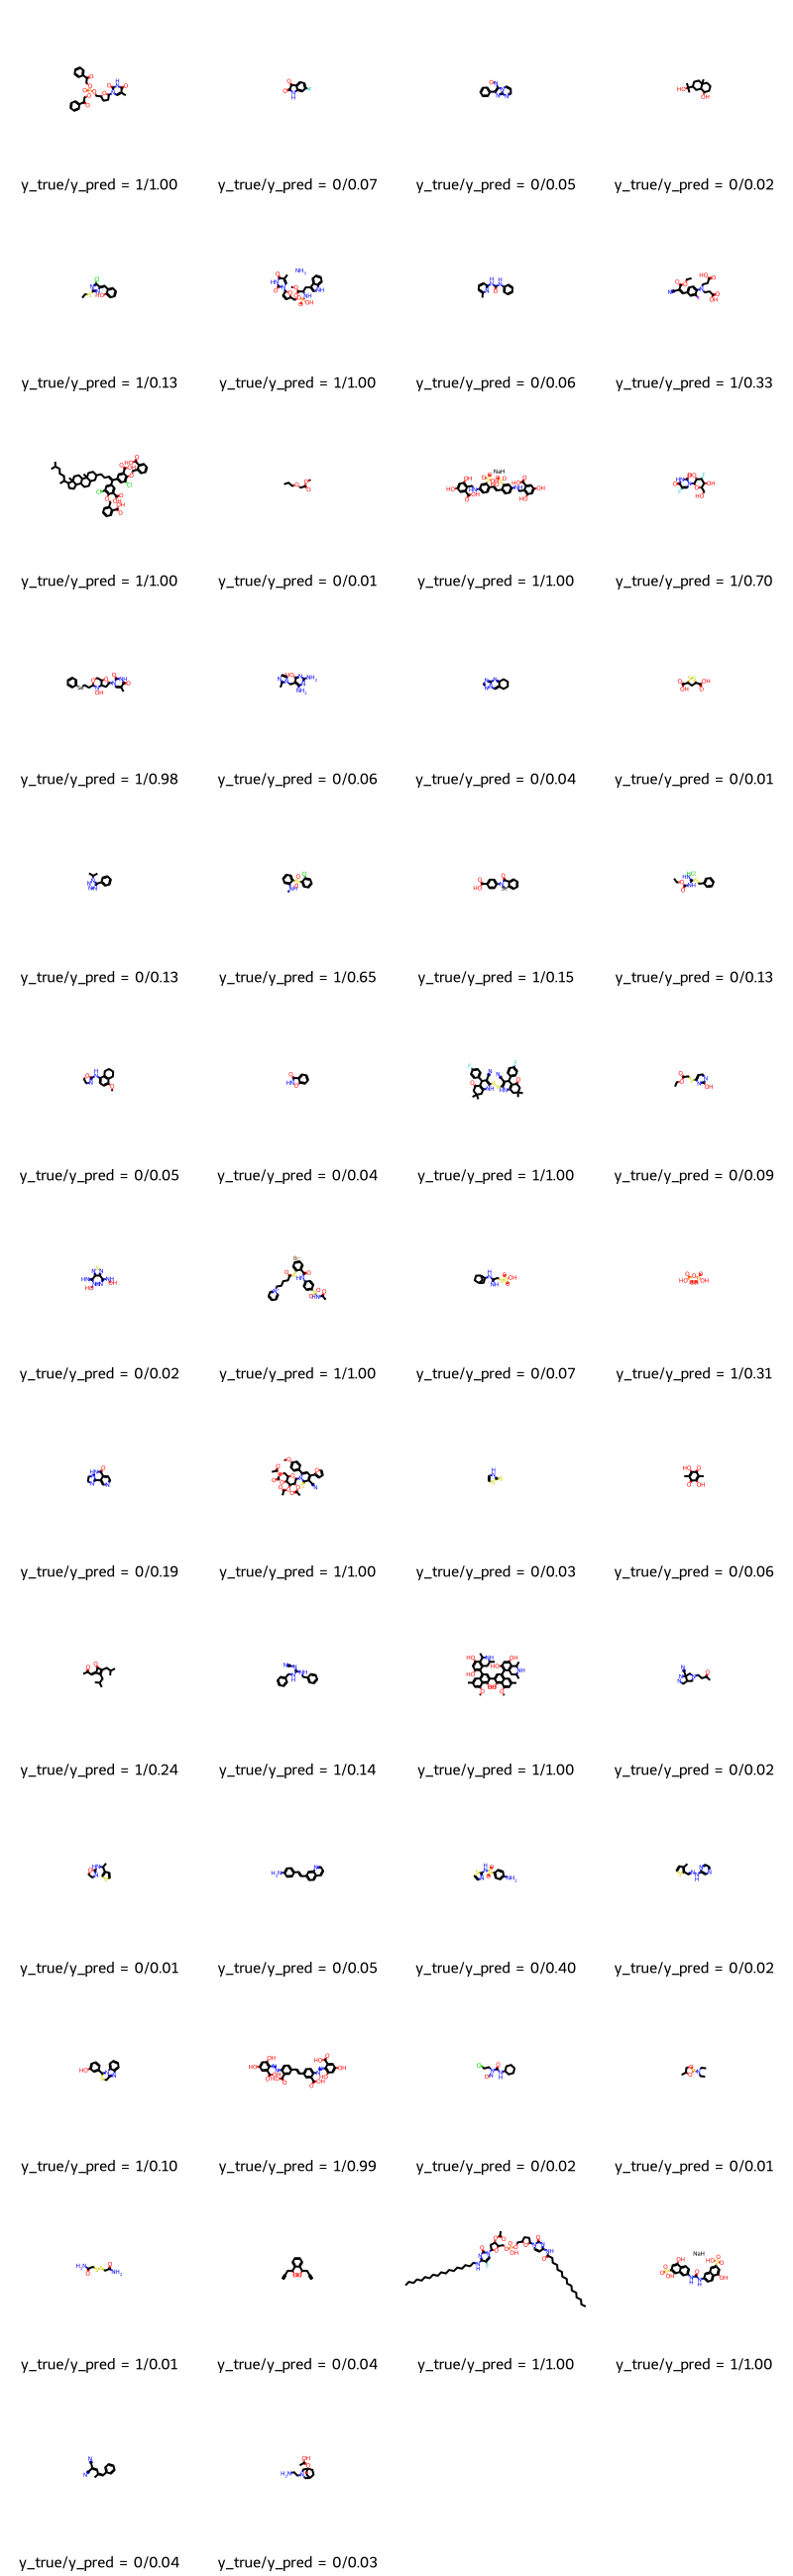

In [ ]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.HIV_active[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)